# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/messagerjulien/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 5.04 MiB/s, done.
Resolving deltas: 100% (23/23), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


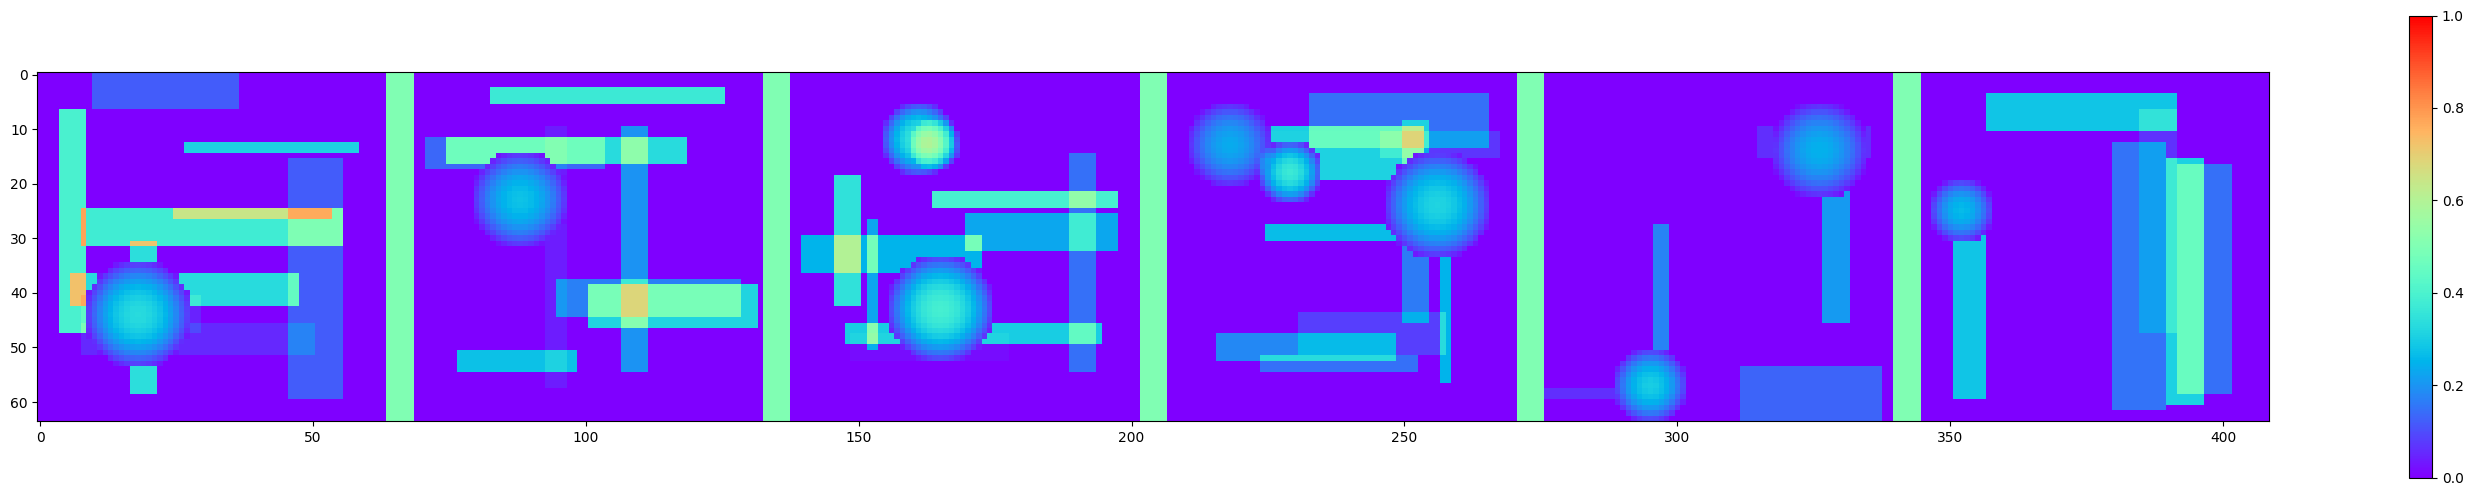

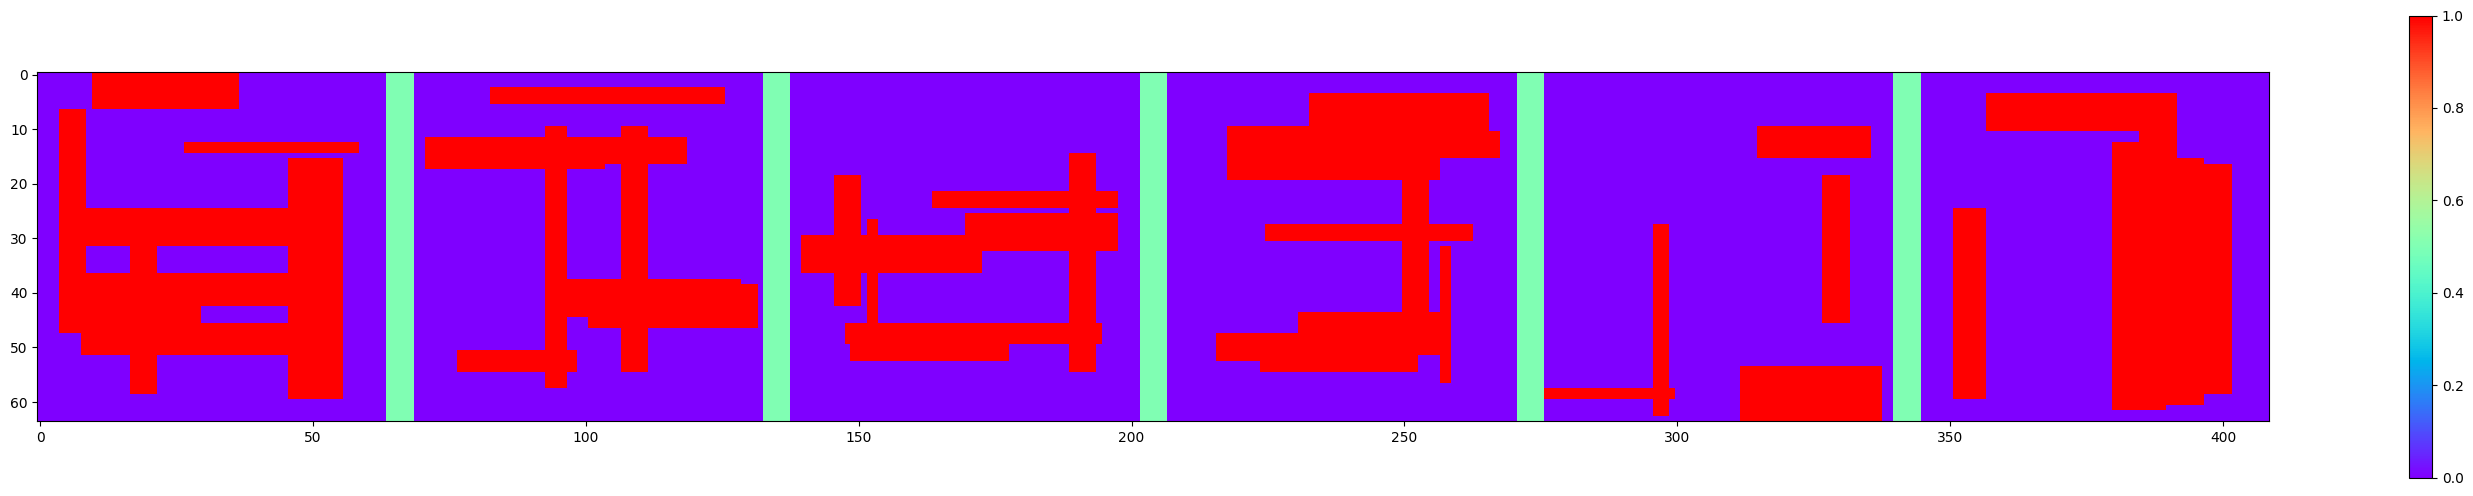

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

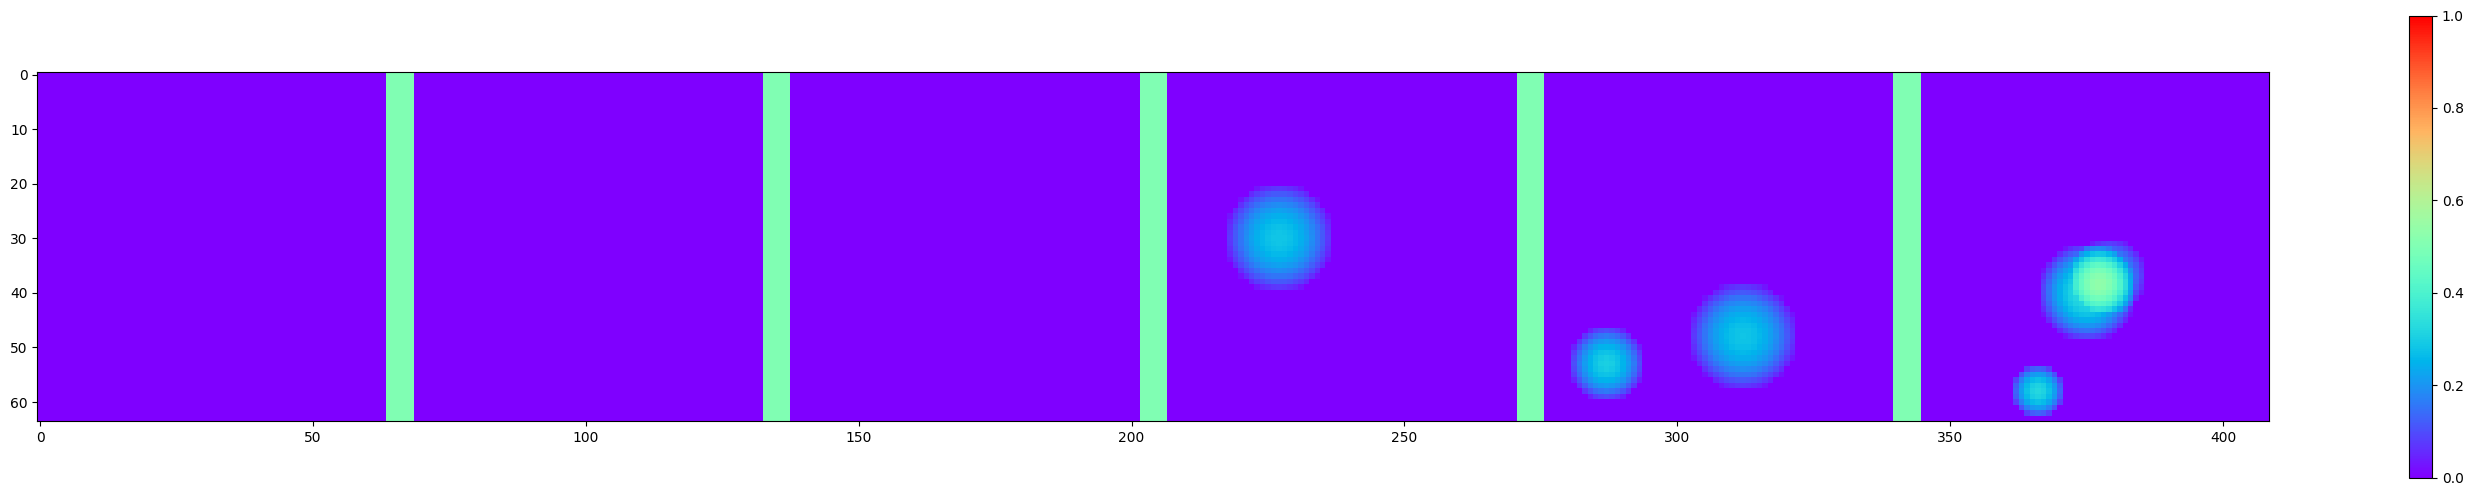

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?



La supervision faible est un cas dans lequel on ne possède pas nécessairement de cible idéale, les cibles sont identifiées grossièrement par exemple. Ici, on ne contient pas de jeu de données sans bruit (disques).


**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [6]:
import torch.nn as nn


# Initialize model and optimizer
ch_in = 1
ch_out = 2
size = 16

model = UNet(ch_in, ch_out, size)
optimizer = torch.optim.Adam(model.parameters(), lr=10**(-4))
model = model.cuda()

# Define the loss function correctly
def criterion(output, target):
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(output, target)

epochs = 40
nbatches = 100
batchsize = 32

train_losses = []

for epoch in range(epochs):
    print("Epoch {}".format(epoch))

    epoch_losses = []

    for i in range(nbatches):  # nbatches = dataset_size / batchsize

        # Generate input data
        image, _ = gen_dr(batchsize)
        image = image.cuda()
        noise = gen_d(batchsize).cuda()
        noise2 = gen_d(batchsize).cuda()

        # Construct input
        input = image + noise + noise2  # Adding two noise images

        # Create target labels (binary segmentation)
        target = (image > 0).long()

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(input)  # Ensure model is used here

        # Compute loss
        loss = criterion(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Store loss
        epoch_losses.append(loss.item())  # Store as float, not tensor

        # Cleanup unnecessary references
        del target, input, loss

    # Compute average loss for epoch
    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 0


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [32, 1, 64, 64]

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).